# Tutorial de Clasificación Binaria con Machine Learning: Predicción de Enfermedades Cardíacas

**Objetivo:** Aprender el flujo de trabajo completo para construir un modelo de Machine Learning que pueda predecir si un paciente tiene una enfermedad cardíaca basándose en datos clínicos.

In [6]:
# Importación de librerías esenciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Componentes de Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    balanced_accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    roc_curve, 
    roc_auc_score,
    auc
)
from sklearn.impute import SimpleImputer

# Librerías para guardar el modelo e interpretarlo
import joblib
import shap

from sklearn import set_config
set_config(transform_output = "pandas")

## Carga y Exploración de Datos (EDA)
Utilizaremos el conjunto de datos "Heart Disease UCI", un dataset clásico en Machine Learning que contiene 14 atributos clínicos para predecir la presencia de enfermedad cardíaca.

Atributos principales:

- `id`: Unique id for each patient
- `age` Age of the patient in years
- `dataset`: place of study
- `sex`: Male / Female
- `cp`: chest pain type ([typical angina, atypical angina, non-anginal, asymptomatic])
- `trestbps`: resting blood pressure (resting blood pressure (in mm Hg on admission to the hospital))
- `chol`: serum cholesterol in mg/dl
- `fbs`: if fasting blood sugar > 120 mg/dl
- `restecg`: resting electrocardiographic results (normal, stt abnormality, lv hypertrophy)
- `thalach`: maximum heart rate achieved
- `exang`: exercise-induced angina (True/ False)
- `oldpeak`: ST depression induced by exercise relative to rest
- `slope`: the slope of the peak exercise ST segment
- `ca`: number of major vessels (0-3) colored by fluoroscopy
- `thal`: [normal; fixed defect; reversible defect]
- `num`: the predicted attribute

In [7]:
# Cargar el dataset
path = 'heart_disease_uci.csv'
df = pd.read_csv(path)

# Columnas a eliminar
to_drop = ['id', 'dataset'] # 'restecg', 'oldpeak', 'slope', 'ca', 'thal'
df.drop(columns=to_drop, inplace=True)
# Renombrar la columna 'num' a 'target' para mayor claridad
df.rename(columns={'num': 'target'}, inplace=True)

# Reemplazar el valor '?' por NaN (Not a Number) para manejarlo como nulo
df.replace('?', np.nan, inplace=True)

# La variable 'target' original tiene valores de 0 a 4. Lo convertiremos a un problema binario:
# 0 = sin enfermedad, 1 = presencia de enfermedad.
df['target'] = (df['target'] > 0).astype(int)

Veamos la estructura y estadísticas básicas de nuestros datos.



In [8]:
# Mostrar las primeras 5 filas
print("Primeras filas del dataset:")
display(df.head())

# Obtener información general: tipos de datos y valores no nulos
print("\nInformación general del dataset:")
df.info()

# Obtener un resumen estadístico de las columnas numéricas
print("\nResumen estadístico:")
display(df.describe())

# Comprobar si hay valores nulos en el dataset
print("\nValores nulos en el dataset:")
df.isnull().sum()

Primeras filas del dataset:


,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0



Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   cp        920 non-null    object 
 3   trestbps  861 non-null    float64
 4   chol      890 non-null    float64
 5   fbs       830 non-null    object 
 6   restecg   918 non-null    object 
 7   thalch    865 non-null    float64
 8   exang     865 non-null    object 
 9   oldpeak   858 non-null    float64
 10  slope     611 non-null    object 
 11  ca        309 non-null    float64
 12  thal      434 non-null    object 
 13  target    920 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 100.8+ KB

Resumen estadístico:


,age,trestbps,chol,thalch,oldpeak,ca,target
count,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.553261
std,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,0.497426
min,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,1.000000
max,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,1.000000



Valores nulos en el dataset:


age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64

Visualicemos los datos para entender mejor las distribuciones y relaciones.



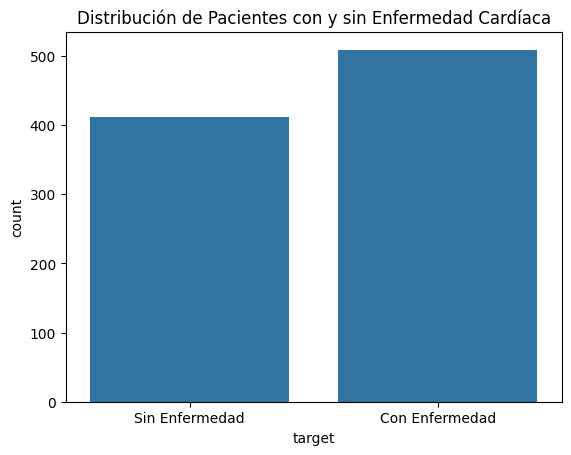

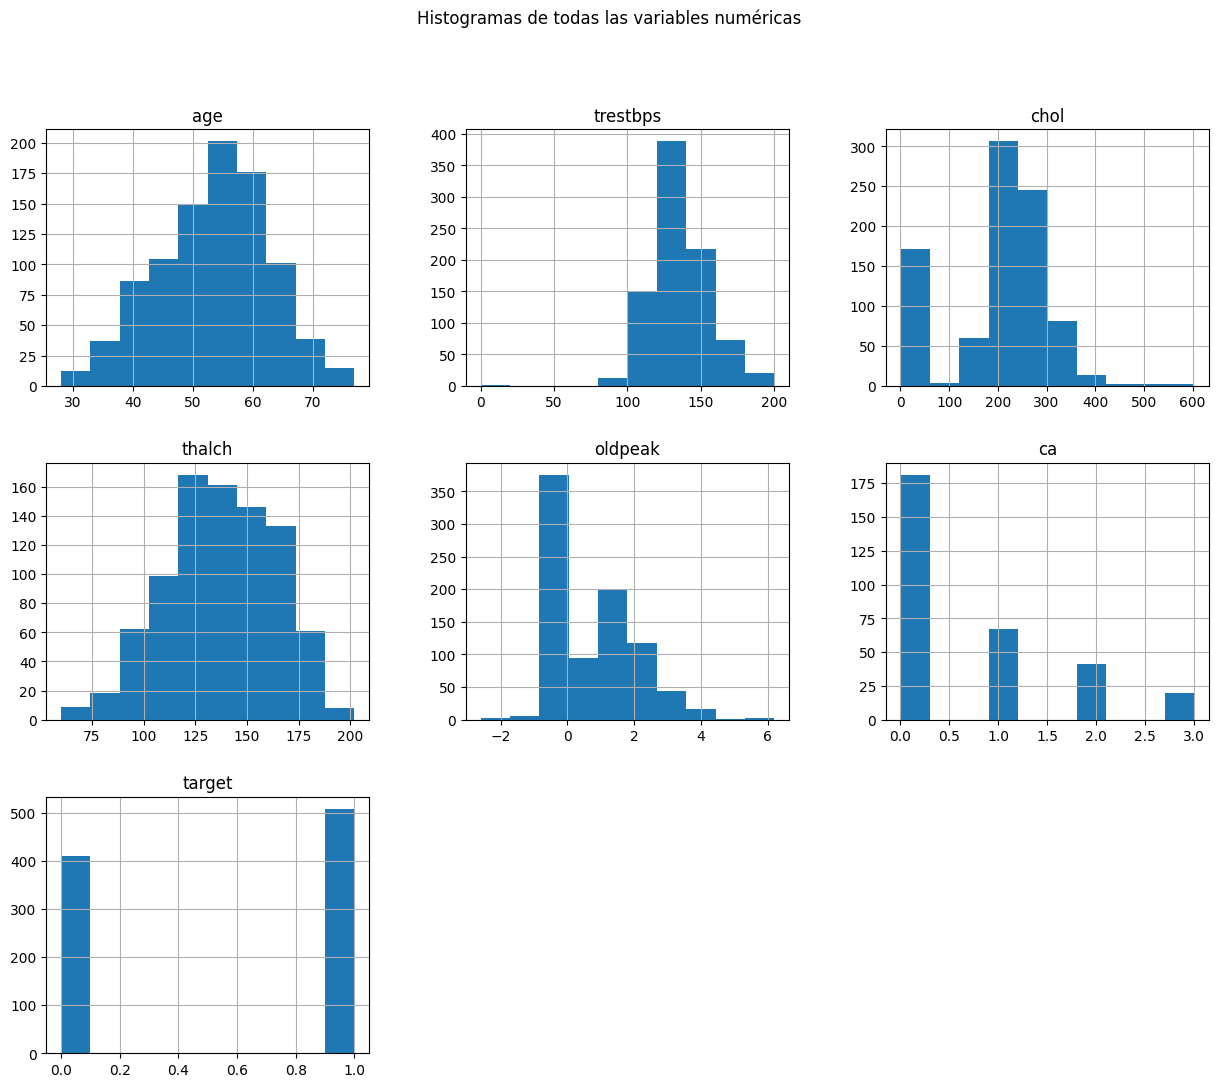

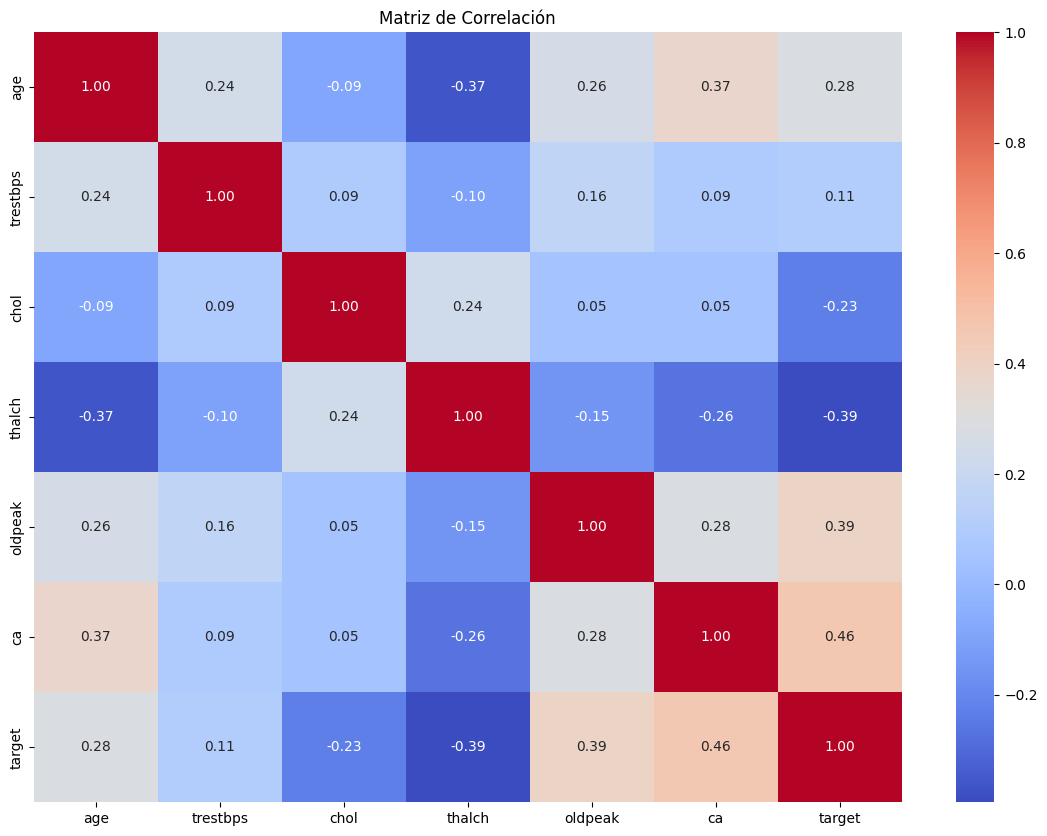

In [9]:
# Distribución de la variable objetivo (target)
sns.countplot(x='target', data=df)
plt.title('Distribución de Pacientes con y sin Enfermedad Cardíaca')
plt.xticks([0, 1], ['Sin Enfermedad', 'Con Enfermedad'])
plt.show()

# Histogramas de las variables numéricas
df.hist(figsize=(15, 12))
plt.suptitle('Histogramas de todas las variables numéricas')
plt.show()

# Matriz de correlación para ver la relación entre variables
plt.figure(figsize=(14, 10))
sns.heatmap(df.select_dtypes(exclude=['object']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

## Preprocesamiento de Datos


In [10]:
X = df.drop('target', axis=1)
y = df['target']

# División en 80% para entrenamiento y 20% para prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")

Tamaño del conjunto de entrenamiento: 736 muestras
Tamaño del conjunto de prueba: 184 muestras


In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

# Identificar columnas numéricas y categóricas
numeric_features = df.select_dtypes(exclude=['object']).columns.tolist()
numeric_features.remove('target')  # Excluir la columna 'target'
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Crear el transformador de preprocesamiento completo
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features)
    ]
)

# Añadir reducción de dimensionalidad como paso final de la pipeline (SelectKBest en vez de PCA)
preprocessor = Pipeline([
    ('col_transform', preprocessor),
    ('selectkbest', SelectKBest(score_func=f_classif, k='all'))  # Puedes ajustar 'k' según lo que desees
])

# Visualizar el preprocesador
preprocessor

Pipeline(steps=[('col_transform',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalch', 'oldpeak', 'ca']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'thal'])])),
                ('selectkbest', SelectKBest(k='all'))])

In [12]:
# Crear el pipeline para la Regresión Logística
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Entrenar el modelo de Regresión Logística
log_reg_pipeline.fit(X_train, y_train)
print("Modelo de Regresión Logística entrenado.")

Modelo de Regresión Logística entrenado.


/Users/mauriciodeoliveirareis/.pyenv/versions/tensorflow_bioinformatics/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/mauriciodeoliveirareis/.pyenv/versions/tensorflow_bioinformatics/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/mauriciodeoliveirareis/.pyenv/versions/tensorflow_bioinformatics/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/mauriciodeoliveirareis/.pyenv/versions/tensorflow_bioinformatics/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/mauriciodeolivei

In [13]:
# Crear el pipeline para Random Forest
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))])

# Entrenar el modelo de Random Forest
rf_pipeline.fit(X_train, y_train)
print("Modelo de Random Forest entrenado.")

Modelo de Random Forest entrenado.


## Evaluación del modelo

Es muy importante el umbral elegido para el modelo, ya que indica a partir de qué valor diferenciamos entre una clase u otra. Por defecto, los modelos emplean 0.5

In [14]:
# Función para imprimir métricas de evaluación
def evaluate_model(y_true, y_proba, model_name, threshold=0.5):
    """
    Imprime métricas de evaluación para un modelo binario.
    Permite especificar un threshold para la clasificación.
    """
    # Si y_proba tiene dos columnas, usamos la probabilidad de la clase positiva
    if y_proba.ndim == 2 and y_proba.shape[1] == 2:
        y_scores = y_proba[:, 1]
    else:
        y_scores = y_proba

    # Recalcular predicciones si el threshold es distinto de 0.5
    if threshold != 0.5:
        y_pred = (y_scores >= threshold).astype(int)
    else:
        y_pred = (y_scores >= 0.5).astype(int)

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensibilidad = recall_score(y_true, y_pred)
    especificidad = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"Métricas para {model_name} (threshold={threshold}):")
    print(f"  AUC-ROC: {roc_auc_score(y_true, y_scores):.3f}")
    print(f"  Bal. Accuracy: {balanced_accuracy_score(y_true, y_pred):.3f}")
    print(f"  Sensibilidad (Recall): {sensibilidad:.3f}")
    print(f"  Especificidad: {especificidad:.3f}")
    print(f"  Precision: {precision_score(y_true, y_pred):.3f}")
    print(f"  F1-Score: {f1_score(y_true, y_pred):.3f}")
    print("-" * 30)

# Predicciones con ambos modelos
# y_pred_log_reg = log_reg_pipeline.predict(X_test)
y_proba_log_reg = log_reg_pipeline.predict_proba(X_test)
evaluate_model(y_test, y_proba_log_reg, "Regresión Logística")

# y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)
evaluate_model(y_test, y_proba_rf, "Random Forest")

Métricas para Regresión Logística (threshold=0.5):
  AUC-ROC: 0.908
  Bal. Accuracy: 0.841
  Sensibilidad (Recall): 0.902
  Especificidad: 0.780
  Precision: 0.836
  F1-Score: 0.868
------------------------------
Métricas para Random Forest (threshold=0.5):
  AUC-ROC: 0.907
  Bal. Accuracy: 0.830
  Sensibilidad (Recall): 0.892
  Especificidad: 0.768
  Precision: 0.827
  F1-Score: 0.858
------------------------------


/Users/mauriciodeoliveirareis/.pyenv/versions/tensorflow_bioinformatics/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mauriciodeoliveirareis/.pyenv/versions/tensorflow_bioinformatics/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mauriciodeoliveirareis/.pyenv/versions/tensorflow_bioinformatics/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Evaluación detallada para Random Forest:


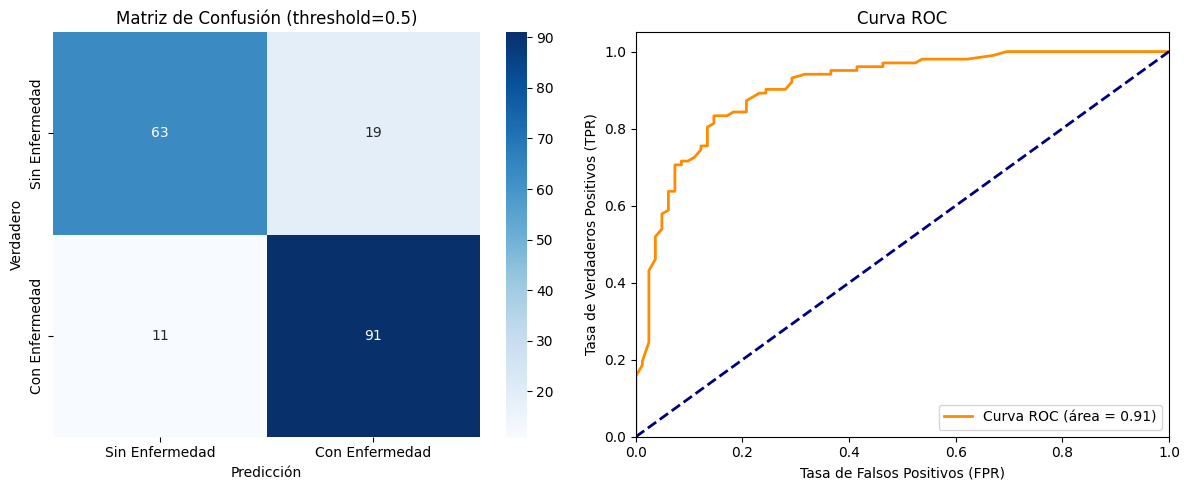

In [15]:
# Función para visualizar la matriz de confusión y la curva ROC
def plot_evaluations(pipeline, X_test, y_test, threshold=0.5):
    # Obtener probabilidades de la clase positiva
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    # Calcular predicciones según el threshold
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Enfermedad', 'Con Enfermedad'], yticklabels=['Sin Enfermedad', 'Con Enfermedad'])
    plt.title(f'Matriz de Confusión (threshold={threshold})')
    plt.ylabel('Verdadero')
    plt.xlabel('Predicción')

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()

print("Evaluación detallada para Random Forest:")
plot_evaluations(rf_pipeline, X_test, y_test)

## Validación Cruzada y Ajuste de Hiperparámetros

In [16]:
# Definir la parrilla de parámetros a probar
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'preprocessor__selectkbest__k': [5, 10, 20, 'all']
}

# Crear el objeto GridSearchCV
# n_jobs=-1 usa todos los procesadores disponibles para acelerar la búsqueda
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=4, verbose=1)

# Iniciar la búsqueda en los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print(f"\nMejores parámetros encontrados: {grid_search.best_params_}")
print(f"Mejor puntuación AUC-ROC: {grid_search.best_score_:.3f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Mejores parámetros encontrados: {'classifier__max_depth': 10, 'classifier__n_estimators': 300, 'preprocessor__selectkbest__k': 'all'}
Mejor puntuación AUC-ROC: 0.876


In [17]:
# Mostrar los resultados de la búsqueda
print("\nResultados de la búsqueda:")
results_df = pd.DataFrame(grid_search.cv_results_)
results_df


Resultados de la búsqueda:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__n_estimators,param_preprocessor__selectkbest__k,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.059889,0.000670,0.007980,0.000276,None,100,5,"{'classifier__max_depth': None, 'classifier__n...",0.779749,0.817542,0.734942,0.767022,0.756828,0.771217,0.027420,34
1,0.068502,0.000655,0.007772,0.000140,None,100,10,"{'classifier__max_depth': None, 'classifier__n...",0.791667,0.823827,0.796670,0.768144,0.813692,0.798800,0.019201,26
2,0.077514,0.001594,0.007663,0.000110,None,100,20,"{'classifier__max_depth': None, 'classifier__n...",0.853659,0.888274,0.860643,0.810980,0.859895,0.854690,0.024908,18
3,0.082934,0.000768,0.007937,0.000186,None,100,all,"{'classifier__max_depth': None, 'classifier__n...",0.881652,0.914916,0.863449,0.820333,0.864572,0.868984,0.030618,9
4,0.108860,0.001012,0.010456,0.000256,None,200,5,"{'classifier__max_depth': None, 'classifier__n...",0.784645,0.816510,0.733820,0.760569,0.754489,0.770007,0.028342,36
5,0.127831,0.002405,0.010317,0.000113,None,200,10,"{'classifier__max_depth': None, 'classifier__n...",0.793792,0.823171,0.793865,0.775720,0.818930,0.801095,0.017635,24
6,0.144950,0.001924,0.010636,0.000156,None,200,20,"{'classifier__max_depth': None, 'classifier__n...",0.861327,0.884522,0.858960,0.817995,0.858305,0.856222,0.021448,14
7,0.165842,0.003498,0.011291,0.000405,None,200,all,"{'classifier__max_depth': None, 'classifier__n...",0.886271,0.916135,0.863262,0.826225,0.867003,0.871779,0.029489,4
8,0.162131,0.003233,0.012992,0.000187,None,300,5,"{'classifier__max_depth': None, 'classifier__n...",0.783352,0.818011,0.733165,0.766835,0.756828,0.771638,0.028321,31
9,0.191278,0.006489,0.015029,0.001323,None,300,10,"{'classifier__max_depth': None, 'classifier__n...",0.790650,0.823640,0.793771,0.779648,0.819865,0.801515,0.017219,23


In [18]:
# Evaluar el mejor modelo encontrado por GridSearchCV
best_model = grid_search.best_estimator_
evaluate_model(y_test, best_model.predict_proba(X_test), "Random Forest Optimizado")

Métricas para Random Forest Optimizado (threshold=0.5):
  AUC-ROC: 0.914
  Bal. Accuracy: 0.836
  Sensibilidad (Recall): 0.892
  Especificidad: 0.780
  Precision: 0.835
  F1-Score: 0.863
------------------------------


## Interpretación del modelo con SHAP

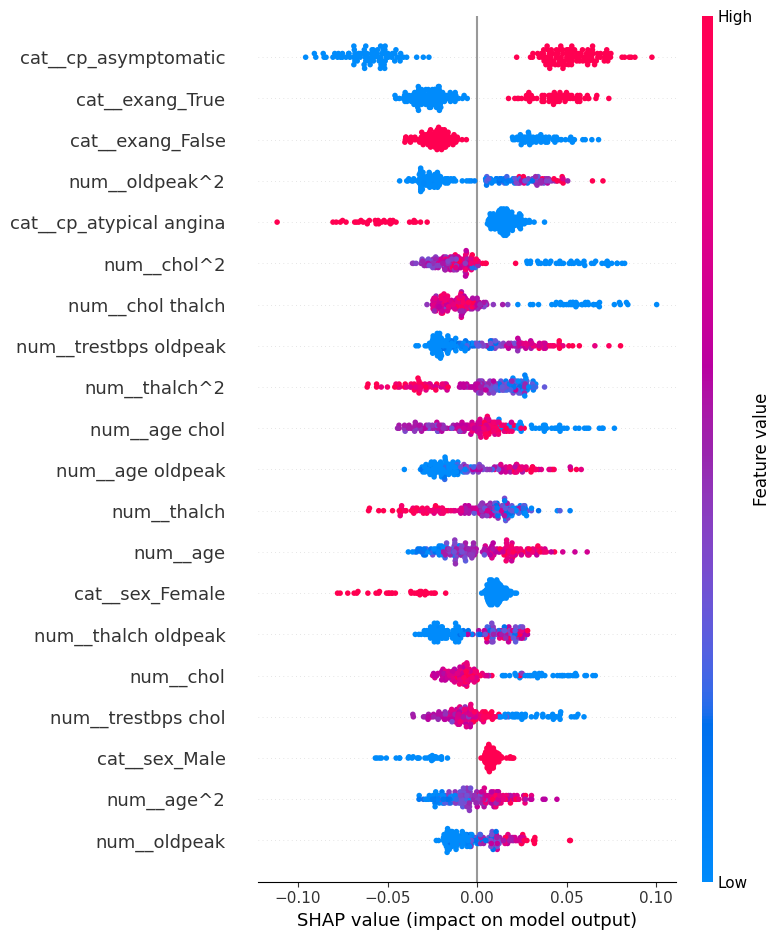

In [19]:
import copy
# 1. Extraer el preprocesador y el modelo entrenados del pipeline
preprocessor_fitted = rf_pipeline.named_steps['preprocessor']
model_fitted = rf_pipeline.named_steps['classifier']

# 2. Transformar los datos de entrenamiento y prueba
X_train_transformed = preprocessor_fitted.transform(X_train)
X_test_transformed = preprocessor_fitted.transform(X_test)

# Obtener nombres de características antes de SelectKBest
feature_names = preprocessor_fitted.named_steps['col_transform'].get_feature_names_out()

# 3. Crear el objeto explainer de SHAP (nueva API)
explainer = shap.TreeExplainer(model_fitted)
shap_values = explainer(X_test_transformed)

# Modificar para que sean aceptados por beeswarm
shap_values_mod = copy.deepcopy(shap_values)
shap_values_mod.values = shap_values_mod.values[:,:,1]
shap_values_mod.base_values = shap_values_mod.base_values[:,1]

# 4. Visualizar los valores SHAP
shap.summary_plot(shap_values_mod)

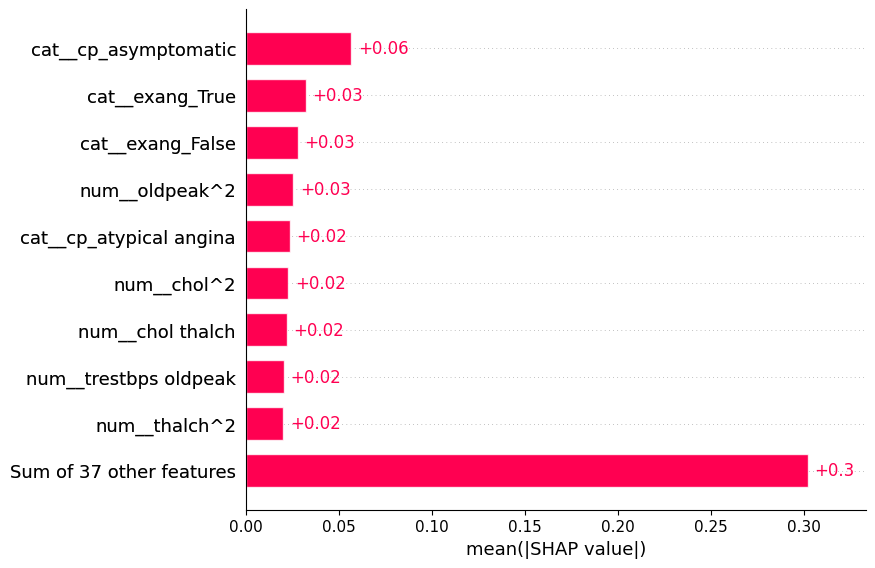

In [20]:
shap.plots.bar(shap_values_mod.abs.mean(0))

In [21]:
def get_individual_shap_values(shap_values, index):

    _shap_values = copy.deepcopy(shap_values)
    _shap_values.values = _shap_values.values[index]
    _shap_values.base_values = _shap_values.base_values[index]
    _shap_values.data = _shap_values.data[index]

    return _shap_values

shap_index = get_individual_shap_values(shap_values_mod, 5)

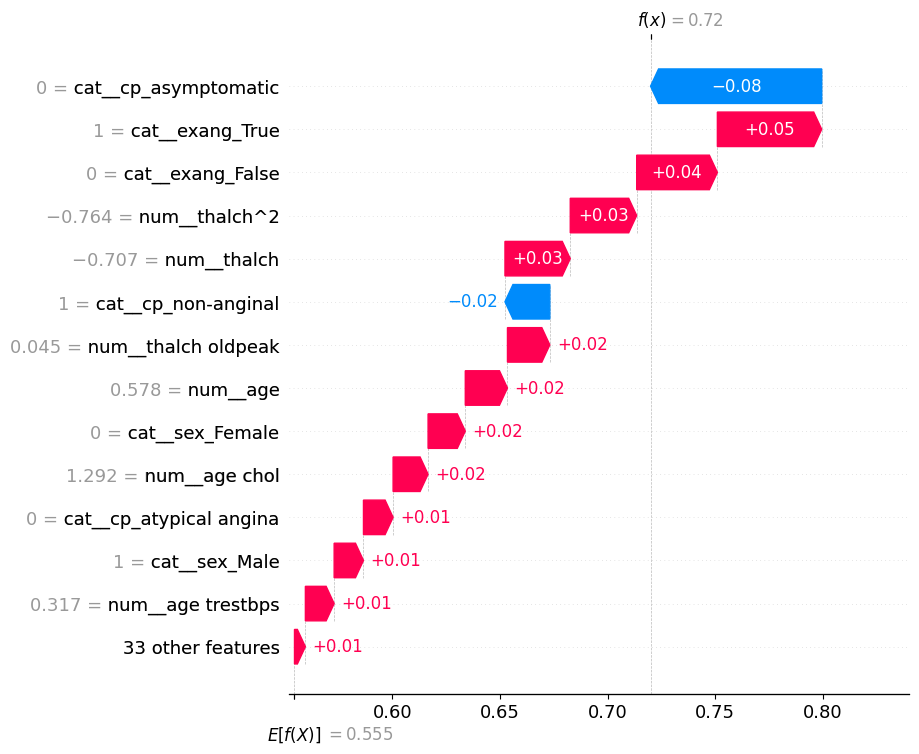

In [22]:
shap.plots.waterfall(shap_index, max_display=14)

## Exportar el modelo y el preprocesador

In [23]:
# Guardar el mejor modelo (pipeline completo) en un archivo
model_filename = 'modelo_prediccion_cardiaca.joblib'
joblib.dump(best_model, model_filename)

print(f"Modelo guardado en '{model_filename}'")

Modelo guardado en 'modelo_prediccion_cardiaca.joblib'


In [24]:
# Cargar el modelo desde el archivo
loaded_model = joblib.load(model_filename)
print("Modelo cargado correctamente.")

Modelo cargado correctamente.


In [25]:
# Crear un ejemplo de un nuevo paciente (como un DataFrame de pandas)
# Es crucial que tenga las mismas columnas que el X_train original
loaded_model.predict(X_test.head(1))  # Predecir con el modelo cargado
print("Predicción para el primer paciente del conjunto de prueba:", loaded_model.predict(X_test.head(1)))

Predicción para el primer paciente del conjunto de prueba: [0]
